# Regression Kriging: Comparing Covariates (Charlotte Harbor)

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Combine Discrete and Continuous Data](#preprocess)
* [3. Charlotte Harbor](#ch)
    * [3.1 Preview](#ch_preview)
    * [3.2 Dissolved Oxygen](#do)
        * [3.2.1 Regression Kriging (covariate: bathymetry](#do_bathy)
        * [3.2.2 Regression Kriging: (covariate: LDI)](#do_ldi)
        * [3.2.3 Regression Kriging: (covariate: PopDen)](#do_pd)
        * [3.2.4 Regression Kriging: (covariate: Water Flow)](#do_wf)
        * [3.2.5 Regression Kriging (covariate: bathymetry+LDI](#do_ldi_bathy)
        * [3.2.6 Regression Kriging (covariate: bathymetry+LDI+Water Flow](#do_ldi_bathy_wf) 
        * [3.2.7 Regression Kriging (covariate: bathymetry+LDI+ Population Density](#do_ldi_bathy_pd) 
        * [3.2.8 Regression Kriging (covariate: bathymetry+LDI+ Population Density + Water Flow](#do_ldi_bathy_pd_wf) 
        * [3.2.9 Interpolation Validation](#do_val_sum)

In [62]:
import time, math, os, importlib
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
from datetime import datetime

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx

import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [63]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [64]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [65]:
# dfDis = pd.read_csv(path + "discrete_0214.csv")
# dfCon = pd.read_csv(path + "continuous_0214.csv")

# dfAll = pd.concat([dfDis,dfCon]).drop(columns = ['Hour'])

# dfAll.to_csv(path + "all_0214.csv")

In [66]:
# Reload modules in external .py files after editing.

dfAll = pd.read_csv(path + "all_0214.csv").drop(columns=['Unnamed: 0','Unnamed: 0.1','RowID','ValueQualifier'])
# Convert SampleDate froms str to date
dfAll['SampleDate'] = pd.to_datetime(dfAll['SampleDate']).dt.date

In [67]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictPara = {"Salinity":'S','Total Nitrogen':'TN','Dissolved Oxygen':'DO','Turbidity':'T','Secchi Depth':'SD'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfAll["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
SpatialRef, method, b_name = '3086','rk', 'ch'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [68]:
# Select managed area
Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'

# Set variables of the program
year, Para = "2017", 'Dissolved Oxygen'

fname = [dictArea[Area],dictPara[Para],year]
dry_input_pt = gis_path+"input_point/{}/{}_{}_{}.shp".format(*fname,'Dry')
wet_input_pt = gis_path+"input_point/{}/{}_{}_{}.shp".format(*fname,'Wet')
boundary_shp = gis_path+ 'managed_area_boundary/{}.shp'.format(b_name)

dry_s_date, dry_e_date = '11/1/2016', '4/30/2017'
wet_s_date, wet_e_date = '5/1/2017', '10/30/2017'

dfDry, gdfDry = misc.preprocess.select_aggr_area_season(dfAll,dry_s_date,dry_e_date, Area, Para)
dfWet, gdfWet = misc.preprocess.select_aggr_area_season(dfAll,wet_s_date,wet_e_date, Area, Para)

gdfDry, gdfWet = gdfDry.to_crs(int(SpatialRef)), gdfWet.to_crs(int(SpatialRef))

gdfDry.to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWet.to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33588\3703230368.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33588\3703230368.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


# 3. Charlotte Harbor <a class="anchor" id="ch"></a>
## 3.1 Preview Data <a class="anchor" id="ch_preview"></a>

In [69]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"managed_area_boundary/ORCP_Managed_Areas_Oct2021.shp")
boundary = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
boundary.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

extent = str(boundary.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

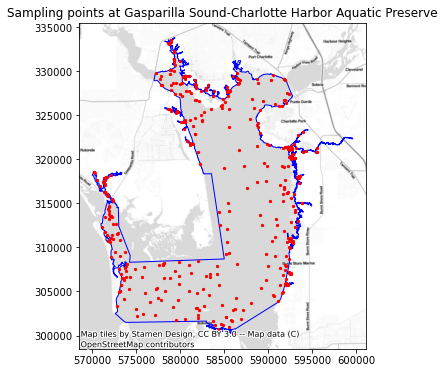

In [70]:
fig, ax = plt.subplots(figsize = (9,6))
boundary.plot(ax = ax, color='none', edgecolor='blue')
gdfWet.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfWet.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 3.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 3.2.1 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

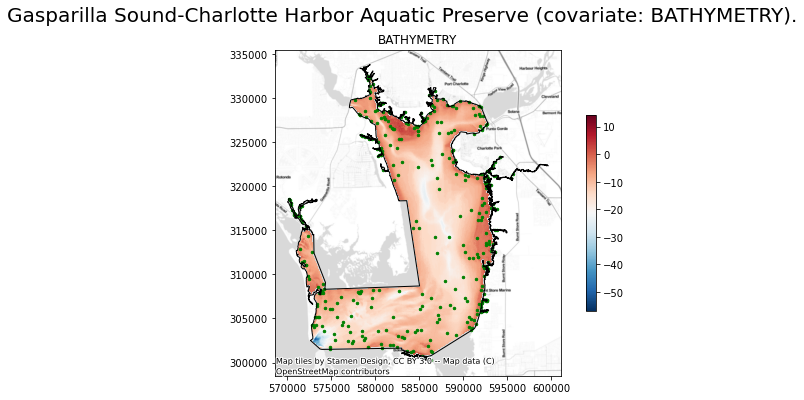

In [71]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax, fig)

RK interpolation

In [72]:
importlib.reload(misc.interpolation)
importlib.reload(misc.preprocess)

season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 856.9033100605011 seconds ---
Start the interpolation with the RK method
--- Time lapse: 819.3740651607513 seconds ---


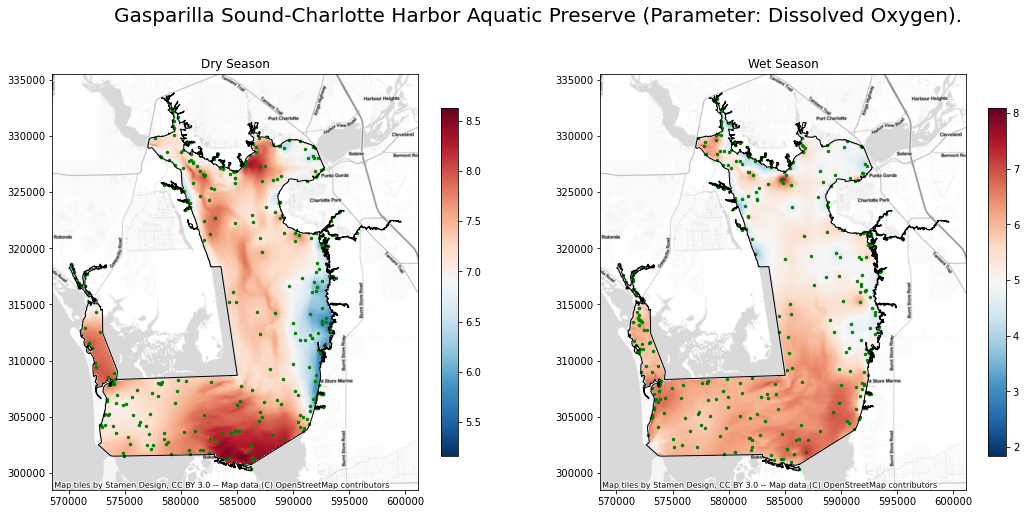

In [73]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK1, 'Wet Season', axes[1],fig)

### 3.2.2 Regression Kriging (covariate: LDI) <a class="anchor" id="do_ldi"></a>


RK interpolation

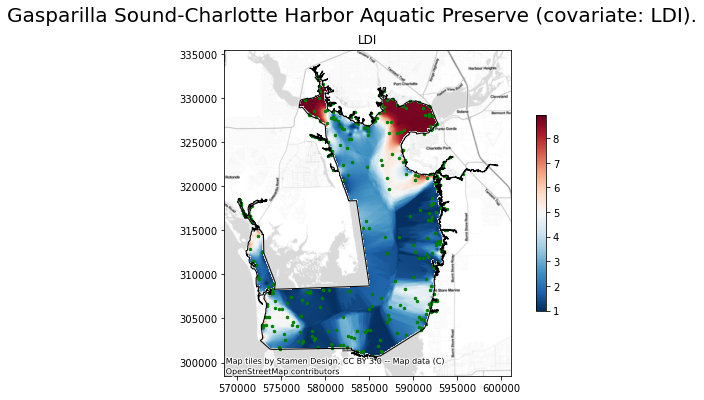

In [74]:
covariate = 'ldi'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax, fig)

In [75]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 843.4815180301666 seconds ---
Start the interpolation with the RK method
--- Time lapse: 853.439909696579 seconds ---


Plot the interpolation result

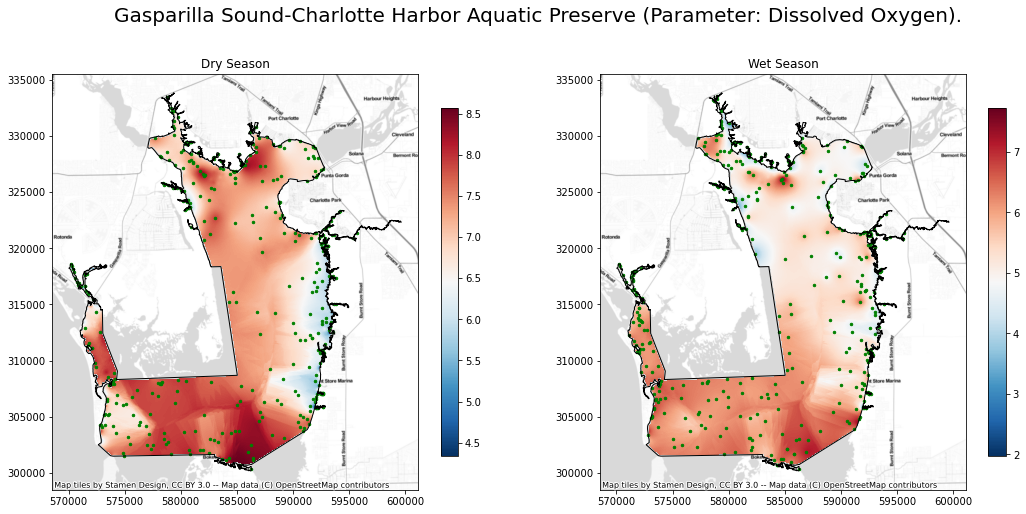

In [76]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK2, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK2, 'Wet Season', axes[1],fig)

### 3.2.3 Regression Kriging (covariate: Population Density) <a class="anchor" id="do_pd"></a>


RK interpolation

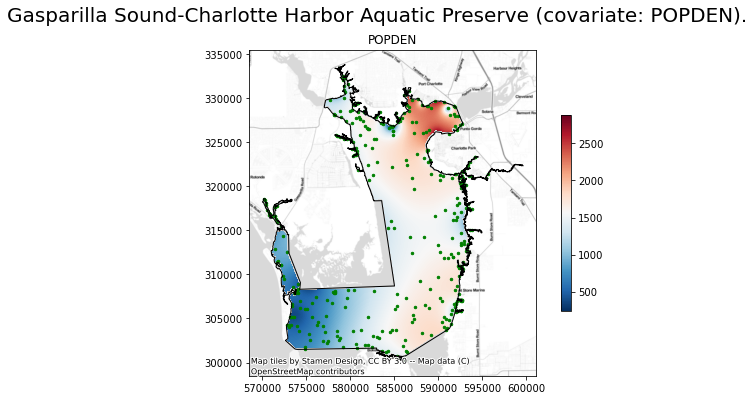

In [77]:
covariate = 'popden'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax, fig)

In [78]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 815.3493947982788 seconds ---
Start the interpolation with the RK method
--- Time lapse: 809.551406621933 seconds ---


Plot the interpolation result

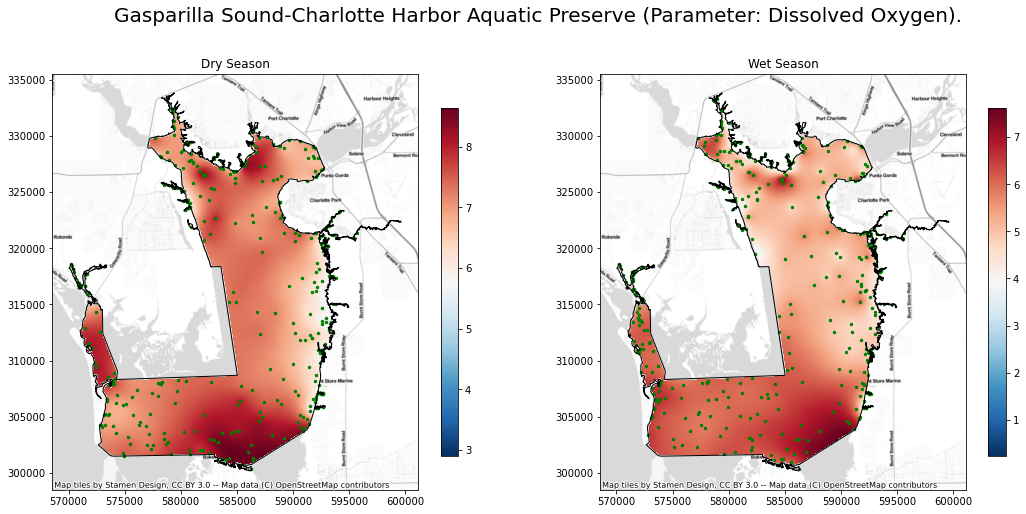

In [79]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK3, 'Wet Season', axes[1],fig)

### 3.2.4 Regression Kriging (covariate: Water Flow) <a class="anchor" id="do_wf"></a>

RK interpolation

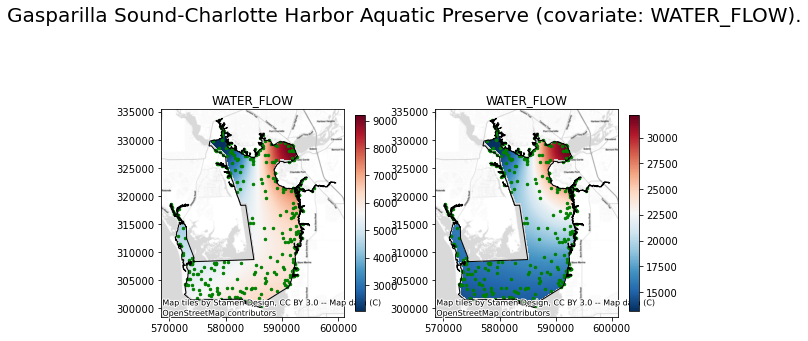

In [84]:
covariate = 'water_flow'
fig, ax = plt.subplots(1,2, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax[0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax[1], fig)

In [81]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = gis_path + "covariates/{}_{}/{}.tif".format(covariate,season.lower(),dictArea[Area])

dryRK4, dryRKStat4 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = gis_path + "covariates/{}_{}/{}.tif".format(covariate,season.lower(),dictArea[Area])

wetRK4, wetRKStat4 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 860.5101456642151 seconds ---
Start the interpolation with the RK method
--- Time lapse: 832.9011447429657 seconds ---


Plot the interpolation result

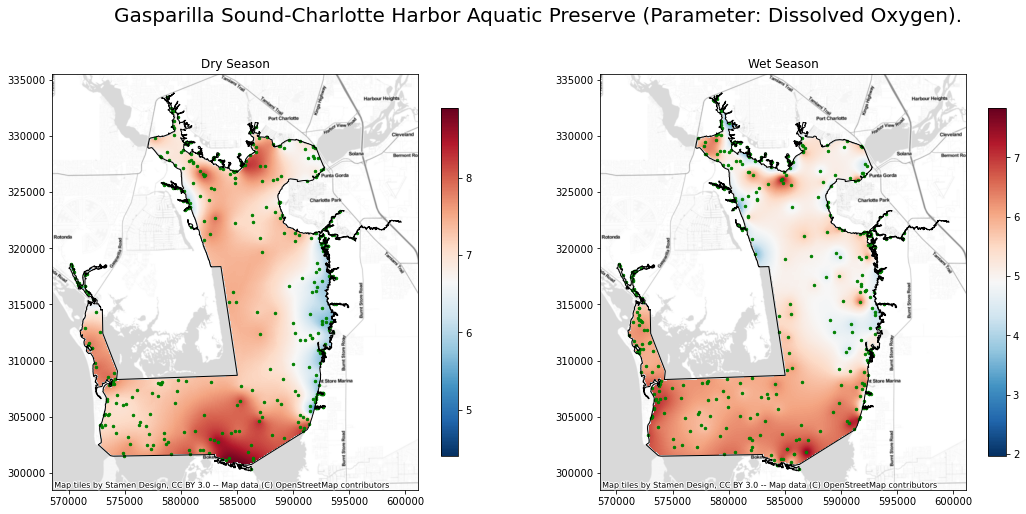

In [82]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK4, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK4, 'Wet Season', axes[1],fig)

### 3.2.5 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_ldi_bathy"></a>


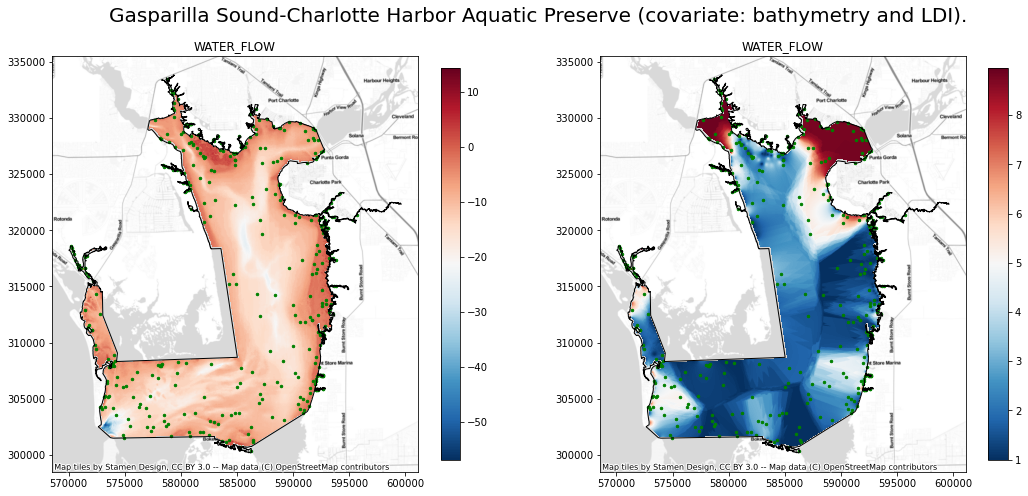

In [85]:
covariate1, covariate2 = 'bathymetry', 'ldi'

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate.upper(), ax[1], fig)

In [86]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

dryRK5, dryRKStat5 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)

wetRK5, wetRKStat5 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 1366.2988798618317 seconds ---
Start the interpolation with the RK method
--- Time lapse: 1391.0329892635345 seconds ---


Plot interpolation results

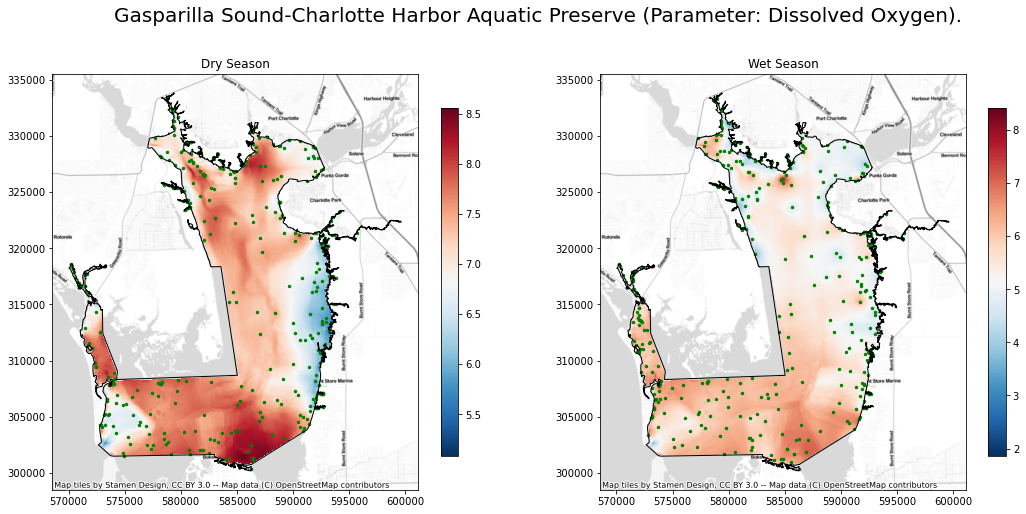

In [87]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK5, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK5, 'Wet Season', axes[1],fig)

### 3.2.6 Regression Kriging (covariate: bathymetry + LDI + Water Flow) <a class="anchor" id="do_ldi_bathy_wf"></a>


In [ ]:
covariate1, covariate2, covariate3 = 'bathymetry', 'ldi', 'water_flow'

fig, ax = plt.subplots(2,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}, {} and {}).".format(Area, covariate1, covariate2.upper(), covariate3),fontsize=20,y=0.95) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate1, ax[0,0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate2, ax[0,1], fig)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate3, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate3, ax[1,0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate3, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate3, ax[1,1], fig)


In [90]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate3,season.lower(),dictArea[Area])

in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

dryRK6, dryRKStat6 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate3,season.lower(),dictArea[Area])

wetRK6, wetRKStat6 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

Start the interpolation with the RK method
--- Time lapse: 1964.7461640834808 seconds ---
Start the interpolation with the RK method
--- Time lapse: 1975.890748500824 seconds ---


Plot interpolation results

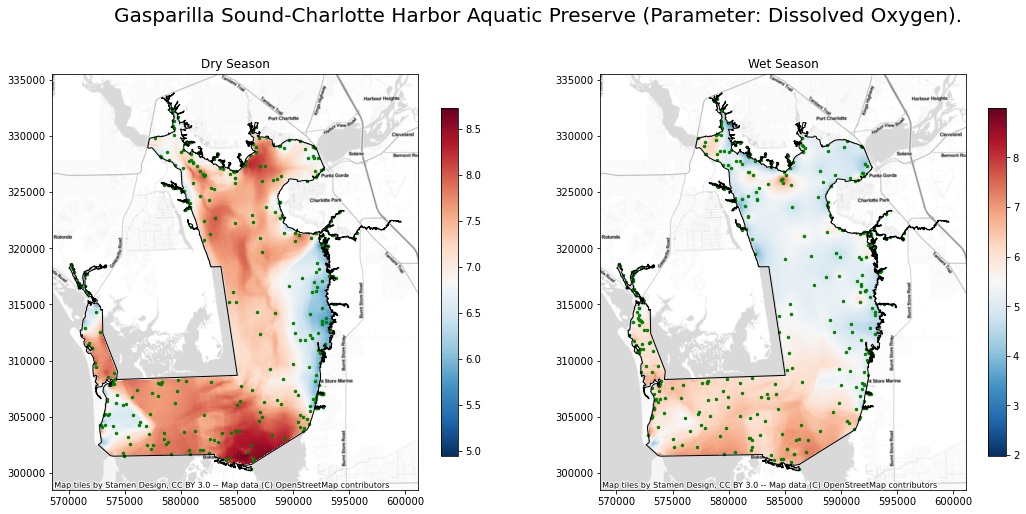

In [91]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK6, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK6, 'Wet Season', axes[1],fig)

### 3.2.7 Regression Kriging (covariate: bathymetry + LDI + PopDen) <a class="anchor" id="do_ldi_bathy_pd"></a>


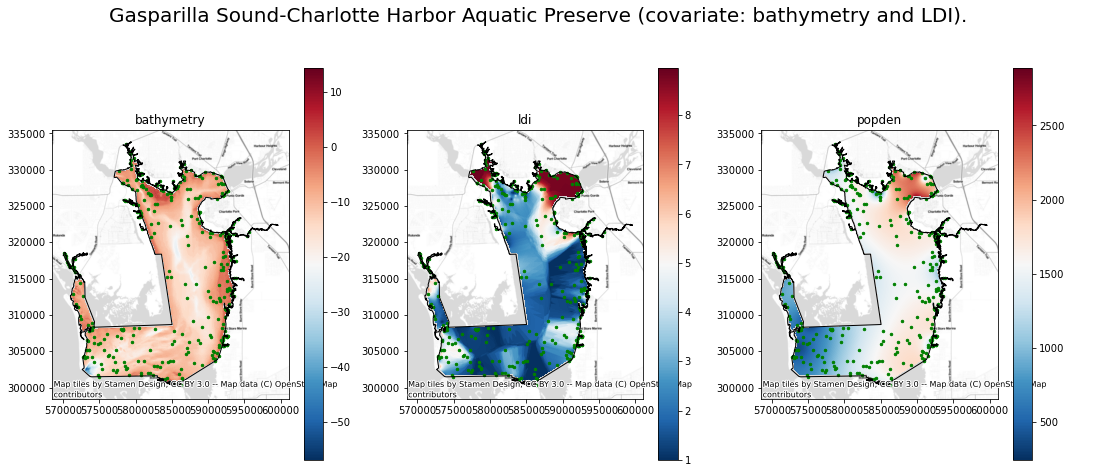

In [93]:
covariate1, covariate2, covariate3 = 'bathymetry', 'ldi', 'popden'

fig, ax = plt.subplots(1,3, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate1, ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate2, ax[1], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate3, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate3, ax[2], fig)

In [ ]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])]

dryRK7, dryRKStat7 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)

wetRK7, wetRKStat7 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method


Plot interpolation results

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK7, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK7, 'Wet Season', axes[1],fig)

### 3.2.8 Regression Kriging (covariate: bathymetry + LDI + PopDen + Water Flow) <a class="anchor" id="do_ldi_bathy_pd_wf"></a>


In [ ]:
covariate1, covariate2, covariate3, covariate4 = 'bathymetry', 'ldi', 'popden', 'water_flow'

fig, ax = plt.subplots(2,3, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.95) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate1, ax[0,0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate2, ax[0,1], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate3, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate3, ax[0,2], fig)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate4, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate4, ax[1,0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate4, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDry,boundary,ra_fname, covariate4, ax[1,1], fig)

In [ ]:
season, value_field, mask = 'Dry','ResultValu', gis_path+ '{}.shp'.format(b_name)
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]

in_features = dry_input_pt
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate4,season.lower(),dictArea[Area])

in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])]

dryRK8, dryRKStat8 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask ,ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

season = 'Wet'
fname = [dictArea[Area], dictPara[Para], year, season.lower(), covariate[0:5]]
in_features = wet_input_pt 
out_ga_layer = gis_path +"ga_layer/{}/{}{}{}_{}.lyrx".format(*fname)
ga_to_raster = gis_path + 'standard_error_prediction/{}/{}{}{}_{}.tif'.format(*fname)
out_raster = gis_path +"output_raster/{}/{}{}{}_{}.tif".format(*fname)
water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate4,season.lower(),dictArea[Area])

wetRK8, wetRKStat8 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, ga_to_raster = ga_to_raster, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

Plot interpolation results

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDry, boundary, dryRK8, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWet, boundary, wetRK8, 'Wet Season', axes[1],fig)

### 3.2.9 Validation Summary <a class="anchor" id="do_val_sum"></a>

In [ ]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3, dryRKStat4, dryRKStat5,dryRKStat6,dryRKStat7,dryRKStat8])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

In [ ]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3,wetRKStat4, wetRKStat5,wetRKStat6,wetRKStat7,wetRKStat8])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

## 3.3 Interpolation of Salinity <a class="anchor" id="s"></a>

Select salinity data

In [ ]:
# Set variables of the program
year = "2017"
Para = 'Salinity'
Para_ab = "S"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

# ---------------------------- Uncomment in the first run --------------------------

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [ ]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

In [ ]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.3.1 Regression Kriging of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

In [ ]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [ ]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.3.2 Regression Kriging (covariate: LDI) <a class="anchor" id="s_ldi"></a>


RK interpolation

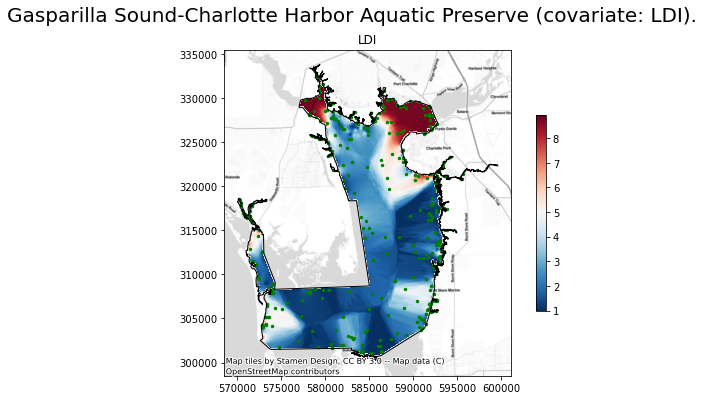

In [44]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [45]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 514.4797081947327 seconds ---
Start the interpolation with the RK method
--- Time lapse: 505.512423992157 seconds ---


Plot the interpolation result

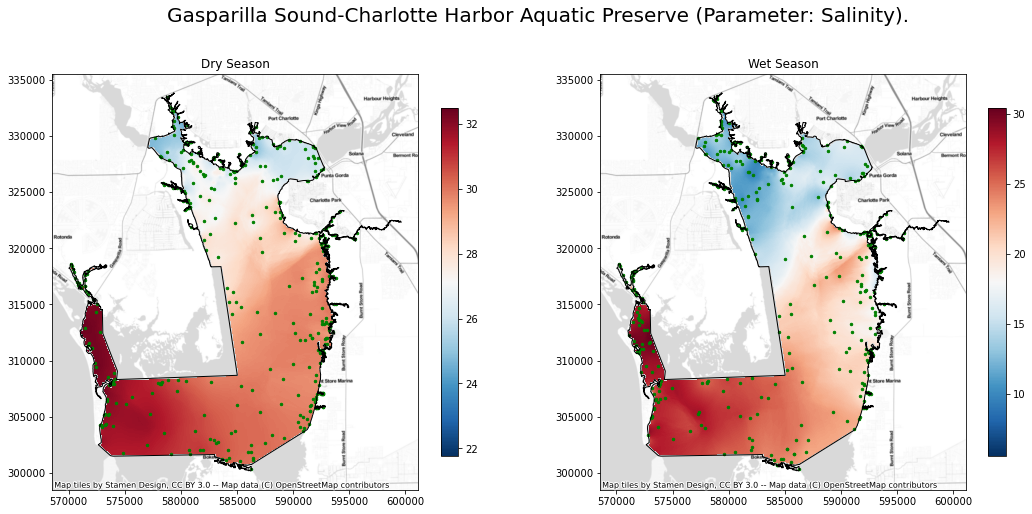

In [46]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.3.3 Regression Kriging (covariate: Population Density) <a class="anchor" id="s_pd"></a>


RK interpolation

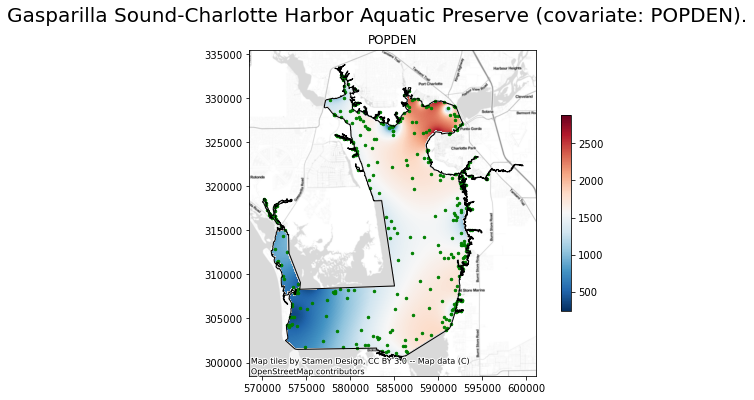

In [47]:
covariate = 'popden'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [48]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 537.1958105564117 seconds ---
Start the interpolation with the RK method
--- Time lapse: 489.7135775089264 seconds ---


Plot the interpolation result

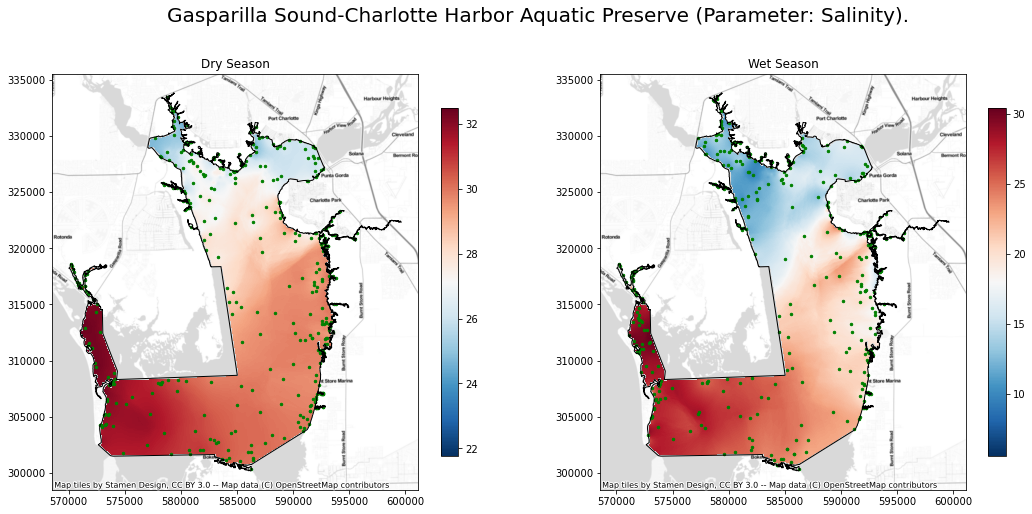

In [49]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.3.4 Regression Kriging (covariate: Water Flow) <a class="anchor" id="s_wf"></a>

RK interpolation

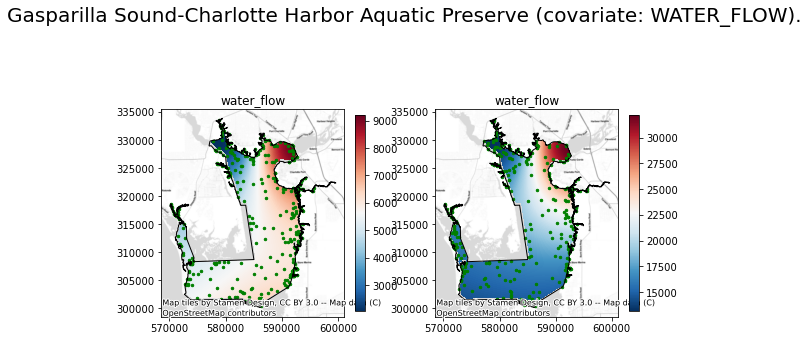

In [50]:
covariate = 'water_flow'
fig, ax = plt.subplots(1,2, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax[0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfWetShp,extentShp,ra_fname, covariate, ax[1], fig)

In [51]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

in_explanatory_rasters = gis_path + "covariates/{}_{}/{}.tif".format(covariate,season.lower(),dictArea[Area])
dryRK4, dryRKStat4 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

in_explanatory_rasters = gis_path + "covariates/{}_{}/{}.tif".format(covariate,season.lower(),dictArea[Area])
wetRK4, wetRKStat4 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 508.28565669059753 seconds ---
Start the interpolation with the RK method
--- Time lapse: 499.0855460166931 seconds ---


Plot the interpolation result

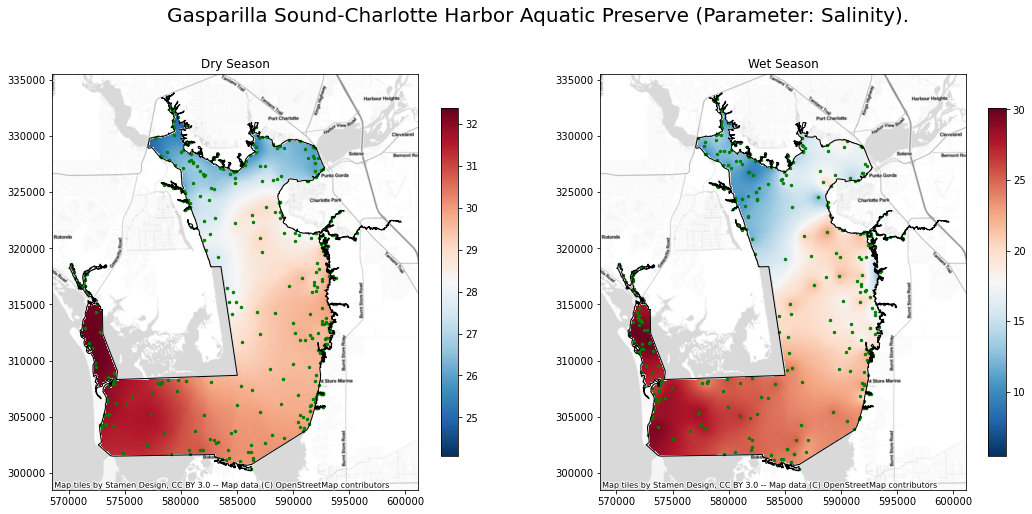

In [52]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK4, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK4, 'Wet Season', axes[1], fig)

### 3.3.5 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="s_ldi_bathy"></a>


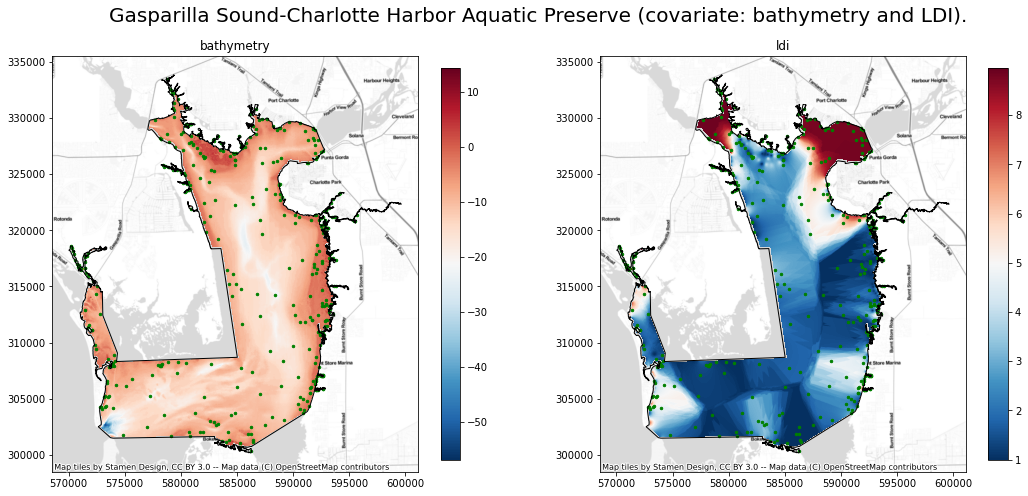

In [53]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [54]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK5, dryRKStat5 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK5, wetRKStat5 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 850.8745667934418 seconds ---
Start the interpolation with the RK method
--- Time lapse: 788.0655655860901 seconds ---


Plot interpolation results

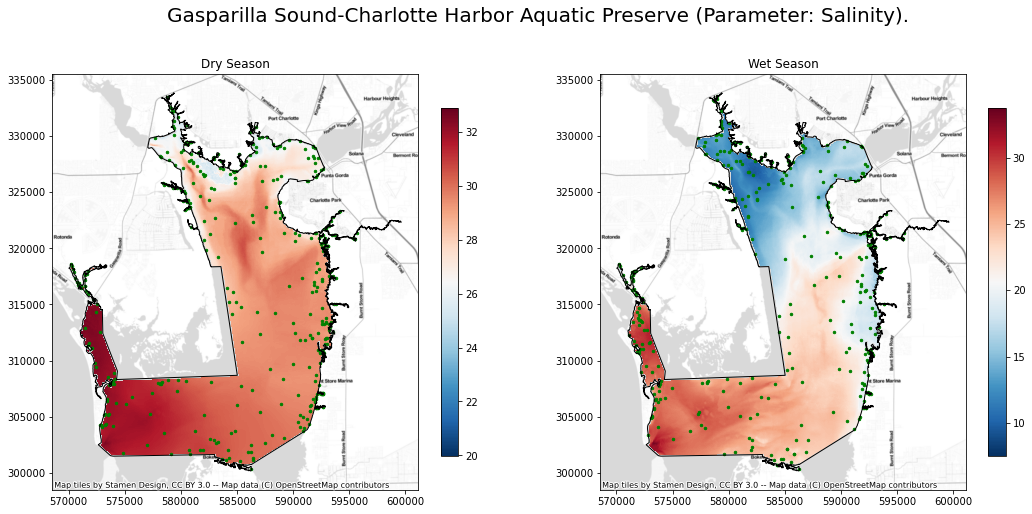

In [55]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK5, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK5, 'Wet Season', axes[1],fig)


### 3.3.6 Regression Kriging (covariate: bathymetry + LDI + Water Flow) <a class="anchor" id="s_ldi_bathy_wf"></a>


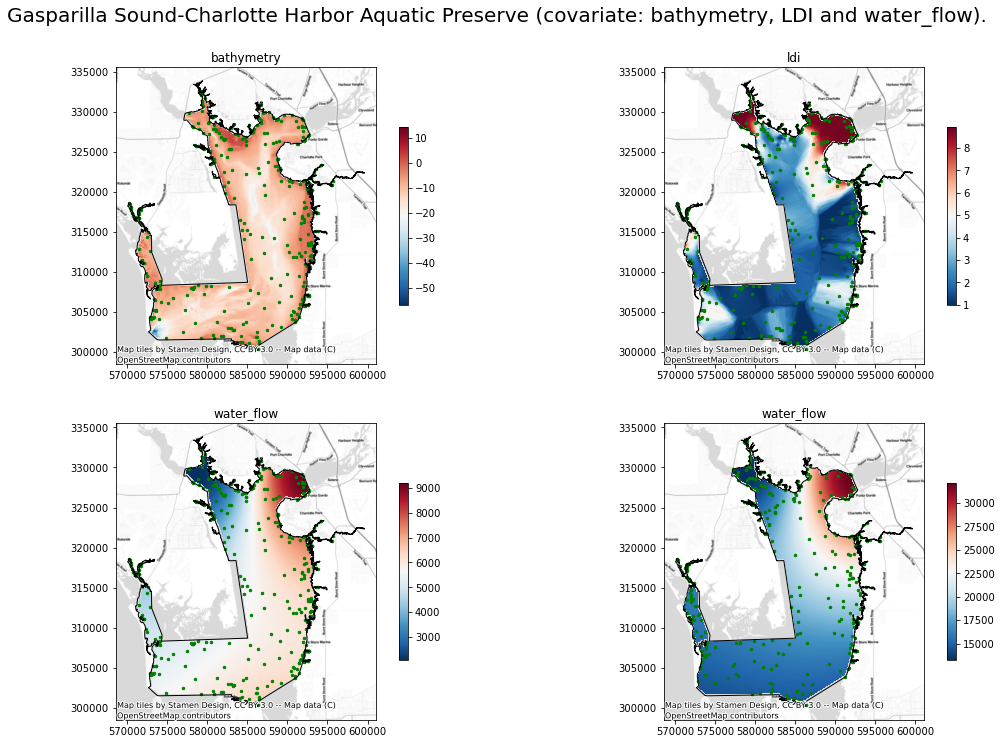

In [56]:
covariate1, covariate2, covariate3 = 'bathymetry', 'ldi', 'water_flow'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(2,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}, {} and {}).".format(Area, covariate1, covariate2.upper(), covariate3),fontsize=20,y=0.95) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0,0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[0,1], fig)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate3,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate3, ax[1,0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate3,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfWetShp,extentShp,ra_fname, covariate3, ax[1,1], fig)

In [57]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]


in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:2])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:2])

water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate3,season.lower(),dictArea[Area])
dryRK6, dryRKStat6 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

season = 'Wet'
in_features = wet_input_pt
water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate3,season.lower(),dictArea[Area])
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:2])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:2])

wetRK6, wetRKStat6 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

Start the interpolation with the RK method
--- Time lapse: 1194.9002828598022 seconds ---
Start the interpolation with the RK method
--- Time lapse: 1153.704719543457 seconds ---


Plot interpolation results

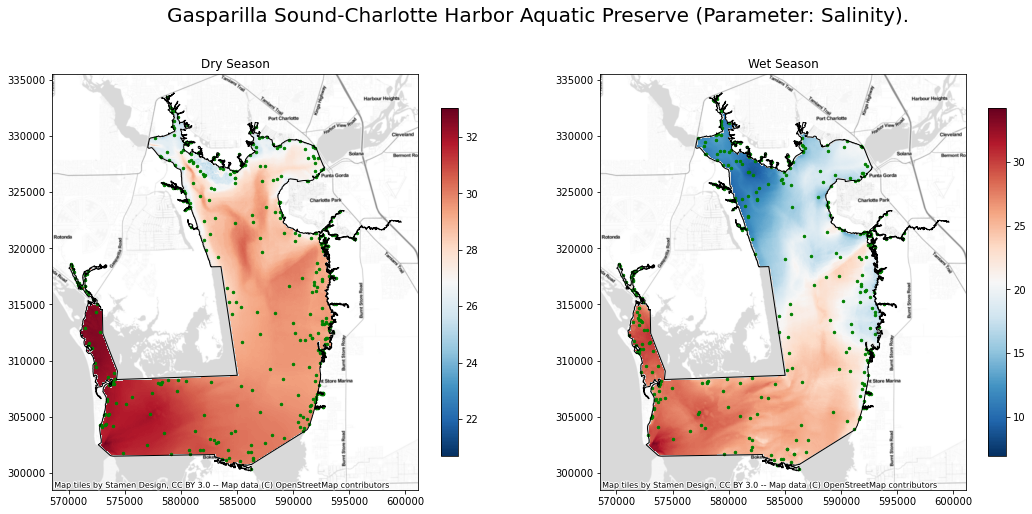

In [58]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK6, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK6, 'Wet Season', axes[1],fig)


### 3.3.7 Regression Kriging (covariate: bathymetry + LDI + PopDen) <a class="anchor" id="s_ldi_bathy_pd"></a>


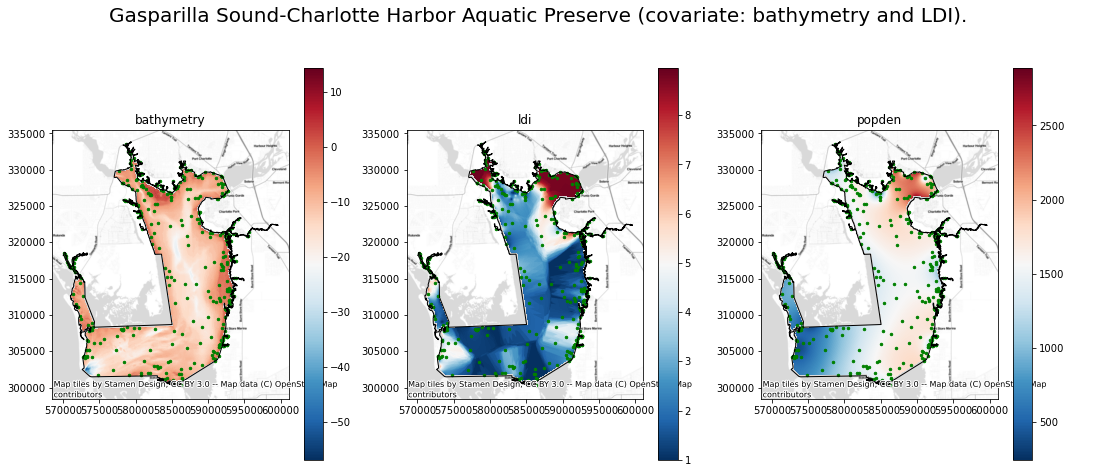

In [59]:
covariate1, covariate2, covariate3 = 'bathymetry', 'ldi', 'popden'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,3, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate3, ax[2], fig)

In [60]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])]

out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK7, dryRKStat7 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK7, wetRKStat7 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 1104.7891592979431 seconds ---
Start the interpolation with the RK method
--- Time lapse: 1106.161463022232 seconds ---


Plot interpolation results

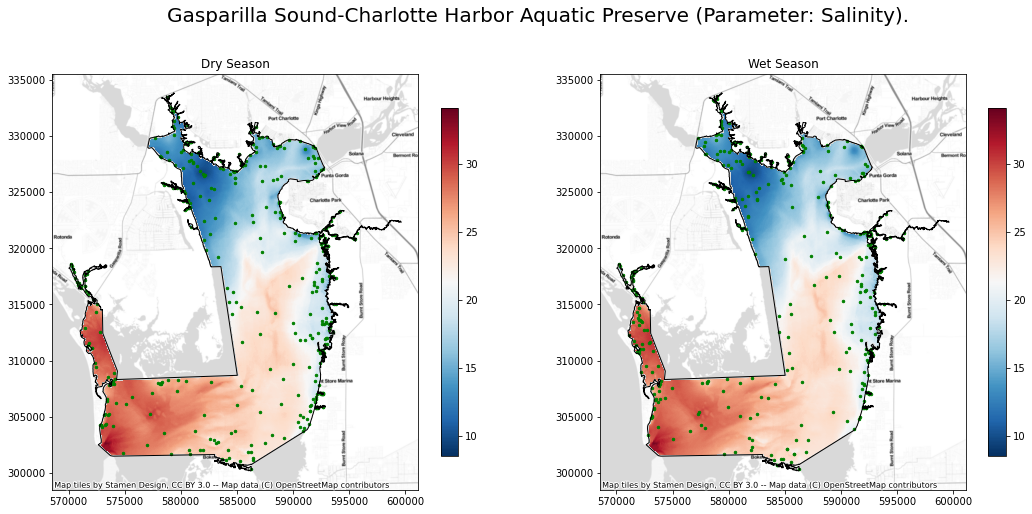

In [61]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK7, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK7, 'Wet Season', axes[1],fig)

### 3.3.8 Regression Kriging (covariate: bathymetry + LDI + PopDen + Water Flow) <a class="anchor" id="s_ldi_bathy_pd_wf"></a>


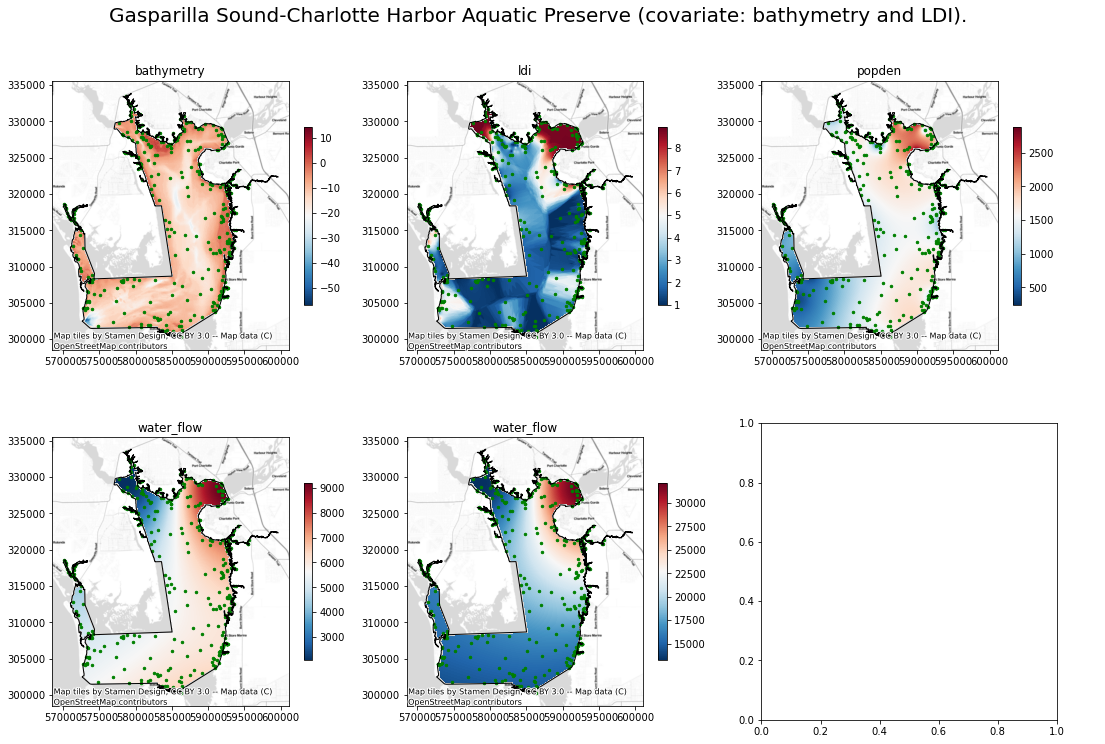

In [62]:
covariate1, covariate2, covariate3, covariate4 = 'bathymetry', 'ldi', 'popden', 'water_flow'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(2,3, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.95) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0,0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[0,1], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate3, ax[0,2], fig)

ra_fname = gis_path + "covariates/{}_dry/{}.tif".format(covariate4,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate4, ax[1,0], fig)

ra_fname = gis_path + "covariates/{}_wet/{}.tif".format(covariate4,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate4, ax[1,1], fig)

In [63]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate3,dictArea[Area])]

out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:1]+'_'+covariate4[0:1])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:1]+'_'+covariate4[0:1])

water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate4,season.lower(),dictArea[Area])
dryRK8, dryRKStat8 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

season = 'Wet'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:1]+'_'+covariate4[0:1])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3]+'_'+covariate3[0:1]+'_'+covariate4[0:1])

water_flow_input = gis_path + "covariates/{}_{}/{}.tif".format(covariate4,season.lower(),dictArea[Area])
wetRK8, wetRKStat8 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters + [water_flow_input])

Start the interpolation with the RK method
--- Time lapse: 1485.51593375206 seconds ---
Start the interpolation with the RK method
--- Time lapse: 1472.871211528778 seconds ---


Plot interpolation results

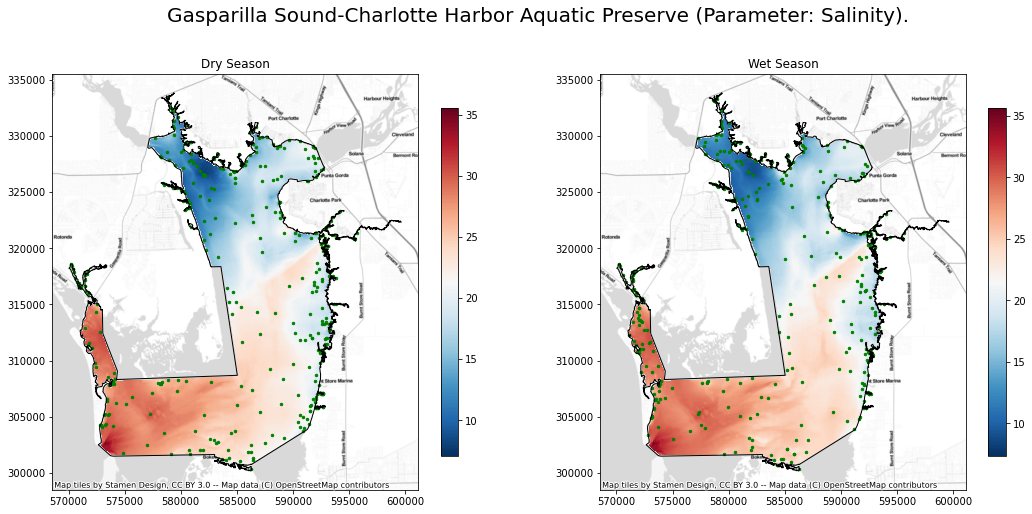

In [64]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK8, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK8, 'Wet Season', axes[1],fig)

### 3.3.9 Validation Summary <a class="anchor" id="s_val_sum"></a>

In [65]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3, dryRKStat4, dryRKStat5,dryRKStat6,dryRKStat7,dryRKStat8])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0399                -0.0222               2.5193
RK    -0.0766                -0.0339               2.5219
RK    -0.0243                -0.0148               2.5201
RK    -0.0217                -0.0150               2.5371
RK    -0.0920                -0.0359               2.4049
RK    -0.0580                -0.0277               2.3676
RK     0.1038                 0.0039               8.7938
RK     0.0800                 0.0049               8.7661

In [66]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3,wetRKStat4, wetRKStat5,wetRKStat6,wetRKStat7,wetRKStat8])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0070                -0.0050               8.8481
RK    -0.0824                -0.0170               8.9670
RK    -0.0343                -0.0095               9.0073
RK    -0.0284                -0.0093               8.9894
RK    -0.1274                -0.0189               8.8234
RK    -0.0447                -0.0101               8.7252
RK     0.1038                 0.0039               8.7938
RK     0.1182                 0.0104               8.7129